### Step-by-step : Dot-product attention layer, a.k.a. Luong-style attention.

In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
tf.__version__, keras.__version__

('2.3.0', '2.4.0')

<img src='image/luong15_fig1.png' width=300px />

Figure 1: Neural machine translation – a stacking recurrent architecture for translating a source sequence A B C D into a target sequence X Y Z. Here, <eos> marks the end of a sentence [1].

<img src='image/luong_global_attention_model.png' width=400px />

Figure 2: Global attentional model – at each time step $t$, the model infers <u>a variable-length alignment weight vector</u> $a_{t}$ based on the current target state $h_{t}$ and all source states $\overline{h}_{s}$. A global context vector $c_{t}$ is then computed as the weighted average, according to $a_{t}$, over all the source states.

The downside of a global attention model is that it has to attend to all words on the source side for each target word, which is computationally costly. 이렇게 source 입력에 대해 attention을 줘야하다보니, Computational cost가 크다. 이는 입력 신호가 길 수록 문제가 됨. 😥

In [4]:
T = 100
D = 128 #hidden_size

Alignment score 는 Timestep (T) 과 Context Vector는 hidden state (D)와 동일한 차원

### Calculating Alignment Scores

Score는 Content-based function  (score is referred as a content-based function) 이며 아래와 같은 3가지 방법.

$$ \Large
\text{score}(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
\textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

, where $h_t$ is a the target hidden state and $h_s$ is source hidden state.

참고로 마지막 Concat버젼의 특징은 다음과 같다 [2].
```
... the decoder hidden state and encoder hidden states are added together first before being passed through a Linear layer. This means that the decoder hidden state and encoder hidden state will not have their individual weight matrix, but a shared one instead, unlike in Bahdanau Attention.
```

$$score_{alignment} = W \cdot tanh(W_{combined}(H_{encoder} + H_{decoder})) $$

After being passed through the Linear layer, a tanh activation function will be applied on the output before being multiplied by a weight matrix to produce the alignment score.


Among the above functions (three different alternatives), here we are using the general scoring option.

$$\Large\text{score}(h_t, h_s) = h_t^\top\mathbf{W}_{a}h_s$$
 
,where $\mathbf{W}_{a}$ is a trainable weight matrix in the attention layer.

$\bar h_s$ is source hidden states.

In [5]:
h_s = keras.Input(shape=(T, D), name='source_hidden_states') # Source hidden states, h_s

$$\Large s_1 = \mathbf{W}_a h_s$$

In [6]:
s1 = layers.Dense(D, use_bias=False, name='attention_score_vec')(h_s) #score_first_part
#              hidden_states            dot               W            =>           score_first_part
# (B, T, D) dot (D, D) => (B, T, D)

In [7]:
h_t = layers.Lambda(lambda h_s: h_s[:, -1, :], output_shape=(D,), name='last_hidden_state')(h_s)

$h_t$ 는 현재 타겟 히든 상태값임. (the current target hidden state)

In [8]:
h_s.shape, s1.shape, h_t.shape

(TensorShape([None, 100, 128]),
 TensorShape([None, 100, 128]),
 TensorShape([None, 128]))

$$\Large\text{score} = \boldsymbol{h}_t^\top  s_1$$

In [9]:
score = layers.dot([s1, h_t], [2, 1], name='attention_score')
#score = layers.dot([h_t, score1], [1, 2], name='attention_score') 

```
tf.keras.layers.dot(
    inputs, axes, normalize=False, **kwargs
)

```
dot = Functional interface to the Dot layer.
* axes = Integer or tuple of integers, axis or axes along which to take the dot product. ( Note that the size of the two selected axes must match.)

D 축으로 맞추었으니 T개가 나오도록. 즉, Score 는 입력 시간축 timestep 길이를 갖게 됨.

In [10]:
score.shape

TensorShape([None, 100])

### Attention weights
A variable-length alignment vector $a_t$ is derived by comparing <u>the current target hidden state </u> $h_t$ with each source hidden state $\bar h_s$.

The general form of the attention calculation relies on the target (decoder) side hidden state and corresponding source (encoder) side state, normalized over all states to get values summing to 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$


In [11]:
attention_weights = layers.Activation('softmax', name='attention_weight_softmax')(score)

In [12]:
model = keras.Model(h_s, attention_weights, name="test")

In [13]:
model.summary()

Model: "test"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
source_hidden_states (InputLaye [(None, 100, 128)]   0                                            
__________________________________________________________________________________________________
attention_score_vec (Dense)     (None, 100, 128)     16384       source_hidden_states[0][0]       
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 128)          0           source_hidden_states[0][0]       
__________________________________________________________________________________________________
attention_score (Dot)           (None, 100)          0           attention_score_vec[0][0]        
                                                                 last_hidden_state[0][0]       

In [14]:
D*D

16384

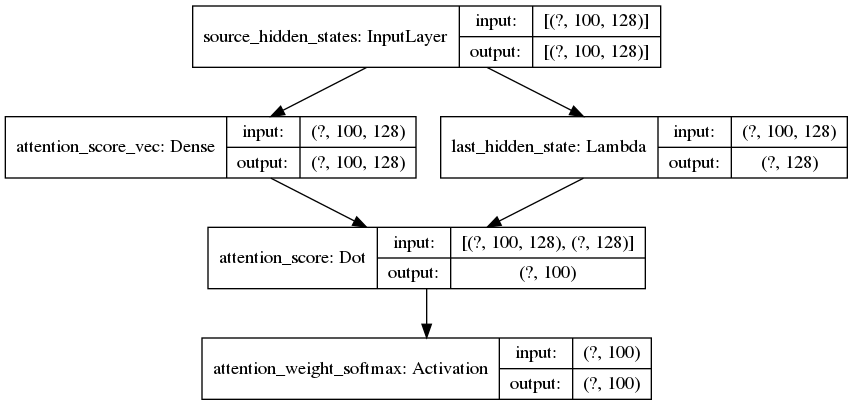

In [15]:
tf.keras.utils.plot_model(model, to_file="model_test.png", show_shapes=True)

### Calculating the Context Vector
Source-side context vector $c_t$ captures relevant source-side information to help predict the current target word $y_t$. The context vector $c_t$ is a weighted average over all the source hidden states, $\bar h_s$. 즉, encoder의 모든 hidden state값들이 필요함. 
This step is the same as the one in Bahdanau Attention where the attention weights are multiplied with the encoder outputs.

Encoder output들의 weighted sum (or average)!  Each weight is the amount of "attention" paid to the corresponding encoder output $\bar h_s$ ! 

* Alignment vector를 이용한 가중평균 관련
```
Alignment vector를 이용한 가중평균이 논문의 모델은 기존에 Bahdanau et al. (2015)가 쓴 모델과 비슷하지만 차이가 있다. 이 논문은 stacked LSTM layer의 맨 위층의 hidden state를 사용한다(encoder, decoder 모두) 이와 달리 Bahdanau et al. (2015)는 bi-directional encoder의 hidden state와 non-stacked uni-directional decoder의 hidden state를 사용했다. 그리하면 본 논문은 그보다 computational path가 단순하다 [3].
```



<img src='image/luong_global_attention_model.png' width=400px />

In [16]:
# (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
context_vector = layers.dot([h_s, attention_weights], [1, 1], name='context_vector') #hidden_states, attention_weights

In [17]:
model2 = keras.Model(h_s, context_vector, name="test2")

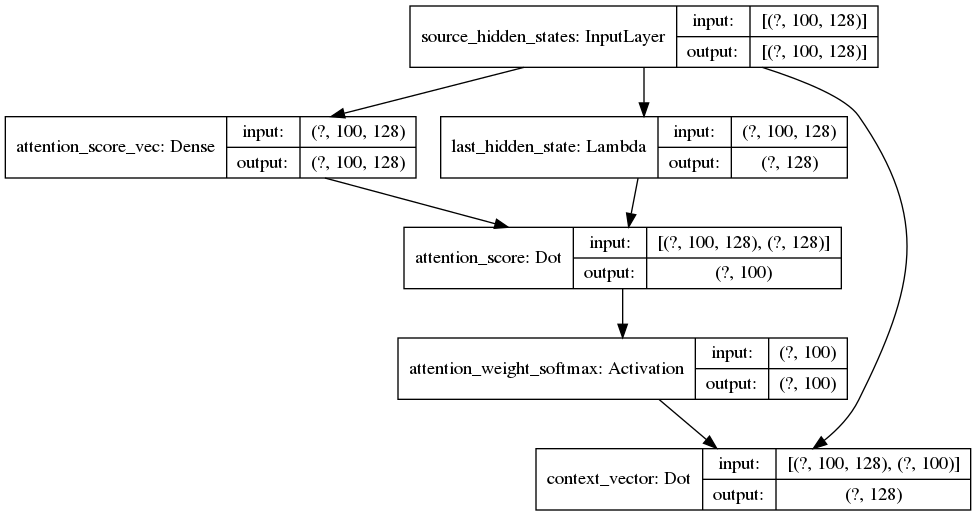

In [18]:
tf.keras.utils.plot_model(model2, to_file="model2_test.png", show_shapes=True)

In [19]:
context_vector.shape, h_t.shape

(TensorShape([None, 128]), TensorShape([None, 128]))

### Attentional hidden state, $\widetilde { h }_t$

Specifically, given the (current) target hidden state $h_t$ and the source-side context vector $c_t$, we employ a simple concatenation layer to combine the information from both vectors to produce an attentional hidden state as follows:

$$\Large \widetilde { h } _{ t }=tanh({ W }_{ c }[c_{ t };h_{ t }])$$

In [20]:
pre_activation = layers.concatenate([context_vector, h_t], name='attention_output')
attention_vector = layers.Dense(D, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)

In [21]:
model3 = keras.Model(h_s, attention_vector, name="test3")

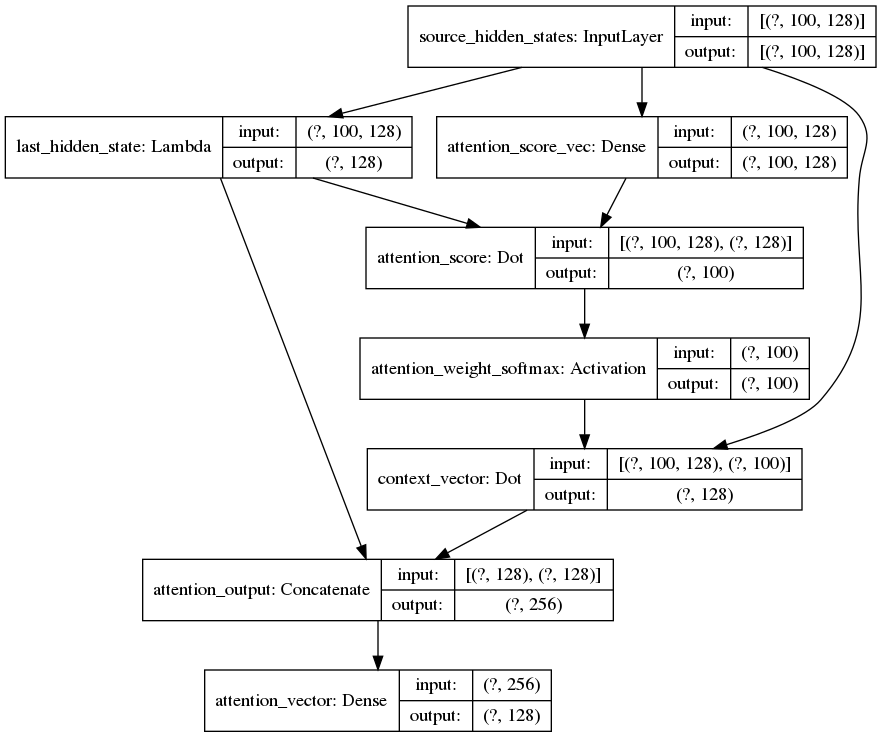

In [22]:
tf.keras.utils.plot_model(model3, to_file="model3_test.png", show_shapes=True)

### A dense layer for classification

In [23]:
y = layers.Dense(1, activation='linear')(attention_vector)

In [24]:
model4 = keras.Model(h_s, y, name="testy")

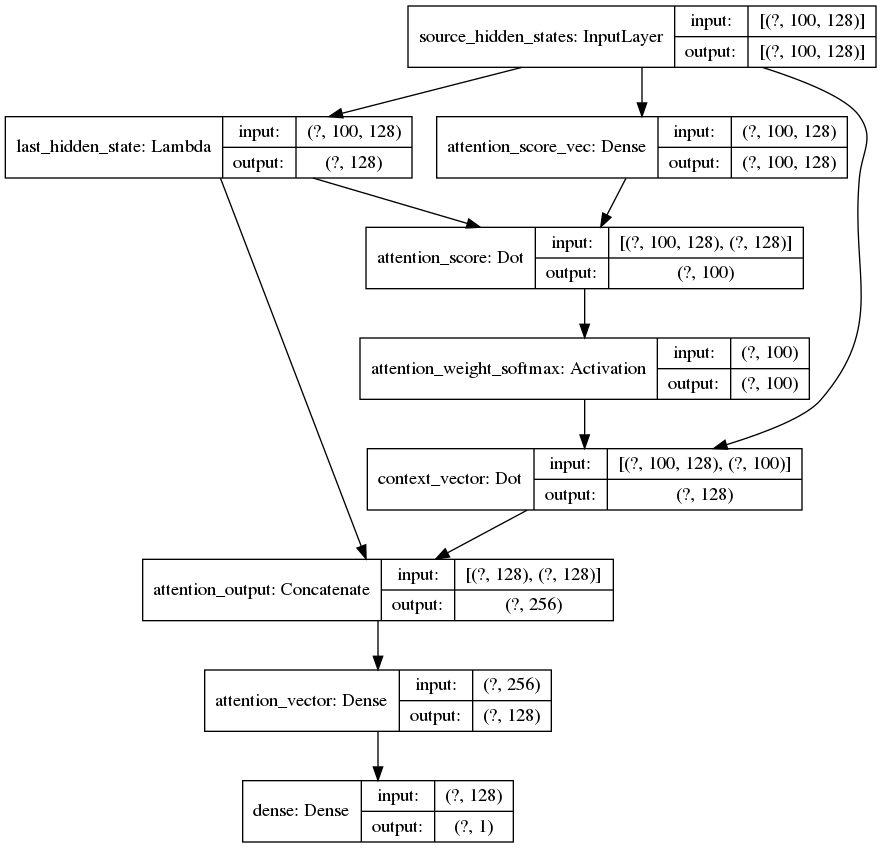

In [25]:
tf.keras.utils.plot_model(model4, to_file="model4_test.png", show_shapes=True)

### TODO
* 설명 검토 & 보충

### References
[1] Luong, M. T., Pham, H., & Manning, C. D. (2015). Effective approaches to attention-based neural machine translation. arXiv preprint arXiv:1508.04025.

[2] Gabriel Loye, Attention Mechanism (2019) https://blog.floydhub.com/attention-mechanism/

[3] 논문 요약: Effective Approaches to Attention-based Neural Machine Translation, https://rokrokss.com/post/2018/05/19/Effective-Approaches-to-Attention-based-Neural-Machine-Translation.html

* Keras Attention Mechanism https://github.com/philipperemy/keras-attention-mechanism
* Attention? Attention! https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html
